In [144]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

custom_colors = [
    "#D55E00",
    "#0072B2",
    "#009E73",
    "#F0E442",
    "#CC79A7",
    "#56B4E9",
    "#E69F00",
]
colormap = ListedColormap(custom_colors, name="custom")

In [145]:
#### Problem 1 ####
def sym_three_point(x_val, step_size):

    numerator = np.sin(x_val + step_size) - np.sin(x_val - step_size)
    denominator = 2 * step_size

    return numerator / denominator


def sym_five_point(x_val, step_size):

    numerator = (
        -np.sin(x_val + 2 * step_size)
        + 8 * np.sin(x_val + step_size)
        - 8 * np.sin(x_val - step_size)
        + np.sin(x_val - 2 * step_size)
    )
    denominator = 12 * step_size

    return numerator / denominator


def forward_two_point(x_val, step_size):

    numerator = np.sin(x_val + step_size) - np.sin(x_val)
    denominator = step_size

    return numerator / denominator


def backward_two_point(x_val, step_size):

    numerator = np.sin(x_val) - np.sin(x_val - step_size)
    denominator = step_size

    return numerator / denominator

In [146]:
step_sizes = [
    0.5,
    0.2,
    0.1,
    0.05,
    0.02,
    0.01,
    0.005,
    0.002,
    0.001,
    0.0005,
    0.0002,
    0.0001,
    0.00005,
    0.00002,
    0.00001,
]
centerpoint = 1

sym_three_point_results = [sym_three_point(centerpoint, i) for i in step_sizes]
sym_five_point_results = [sym_five_point(centerpoint, i) for i in step_sizes]
forward_two_point_results = [forward_two_point(centerpoint, i) for i in step_sizes]
backward_two_point_results = [backward_two_point(centerpoint, i) for i in step_sizes]

problem1df = pd.DataFrame(
    {
        "Step Sizes": step_sizes,
        "Symmetric Three Point": sym_three_point_results,
        "Forward Two Point": forward_two_point_results,
        "Backward Two Point": backward_two_point_results,
        "Symmetric Five Point": sym_five_point_results,
    }
)
latex_code = problem1df.to_latex(index=False)

true_value = np.cos(1)

problem1errordf = pd.DataFrame(
    {
        "Step Sizes": step_sizes,
        "Symmetric Three Point": sym_three_point_results - true_value,
        "Forward Two Point": forward_two_point_results - true_value,
        "Backward Two Point": backward_two_point_results - true_value,
        "Symmetric Five Point": sym_five_point_results - true_value,
    }
)

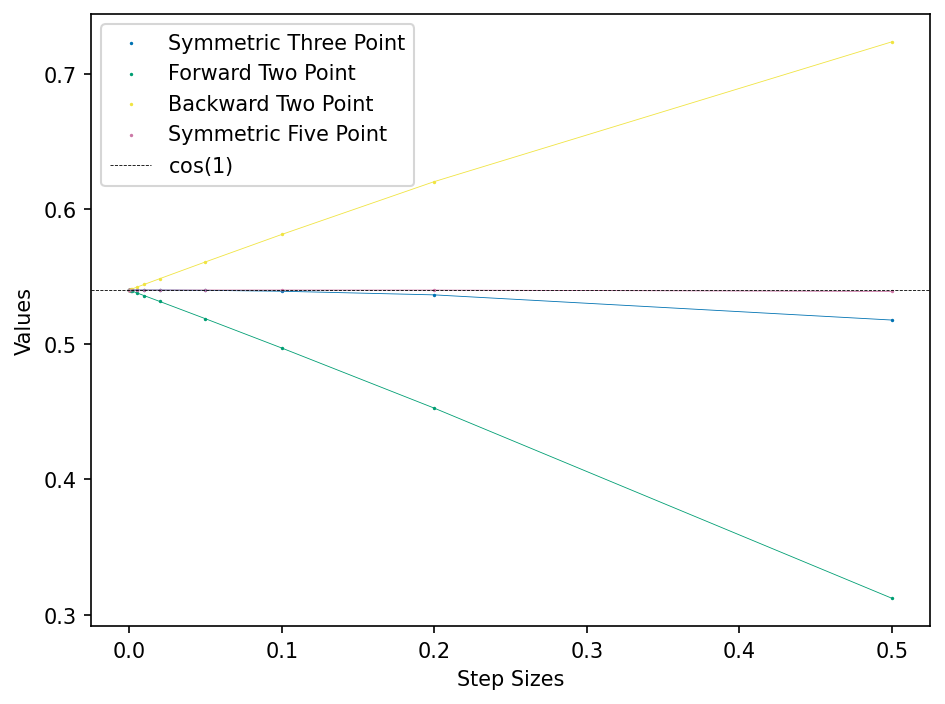

In [147]:
plt.figure(dpi=150)
for n, i in enumerate(problem1df):
    color = colormap(n)
    if "Step Sizes" == i:
        pass
    else:
        plt.scatter(
            problem1df["Step Sizes"],
            problem1df[f"{i}"],
            label=f"{i}",
            s=0.4,
            color=color,
        )
        plt.plot(problem1df["Step Sizes"], problem1df[f"{i}"], lw=0.4, color=color)
plt.axhline(np.cos(1), ls="dashed", c="black", label=r"$\cos(1)$", lw=0.4)
plt.legend()
plt.xlabel("Step Sizes")
plt.ylabel("Values")
plt.tight_layout()
# plt.savefig("Num_Methods/RandomNumMethods/problem1.png")
plt.show()

In [148]:
def depth(N: int, Z: int, pn: str):
    if pn == "p":
        return -51 - 33 * (N - Z) / (N + Z)
    elif pn == "n":
        return -51 + 33 * (N - Z) / (N + Z)
    else:
        raise ValueError(
            "Invalid particle type. Use 'p' for protons or 'n' for neutrons."
        )


def woods_saxon_potential(N, Z, pn, r_vect, R, a):
    V_depth = depth(N, Z, pn)
    potential = V_depth / (1 + np.exp((r_vect - R) / a))
    return potential


def harmonic_oscillator_potential(N, Z, pn, r_vect, omega=1):
    potential = 0.5 * omega**2 * r_vect**2 + depth(N, Z, pn)
    return potential


def spin_orbit_potential(s, N, Z, pn, r_vect, R, a):
    if "up" == s:
        ev = 0.5 * l
    elif "down" == s:
        ev = -0.5 * (l + 1)
    else:
        raise ValueError("Invalid spin. Use 'up' or 'down'.")
    V_depth = depth(N, Z, pn)
    first_term = V_depth / (1 + np.exp((r_vect - R) / a))

    def woods_saxon_derivative(r_vect, R, a):
        ws_term = 1 / (1 + np.exp((r_vect - R) / a))
        return np.gradient(ws_term, r_vect)

    derivative_term = woods_saxon_derivative(r_vect, R, a)
    spin_orbit = (
        (-0.44 * depth(N, Z, pn)) * ev * (r0**2) * (1 / r_vect) * derivative_term
    )
    potential = first_term + spin_orbit
    return potential


def solve_schrodinger(
    l: int,
    r_min: float,
    r_max: float,
    grid_size: int,
    r0: float,
    a: float,
    N: int,
    Z: int,
    s: str = "up",
    omega: float = 2,
    potential_type: str = "woods-saxon",
    pn: str = "p",
):
    """
    Solves the Schrödinger equation for Woods-Saxon, Harmonic Oscillator, or Spin-Orbit potential.

    Args:
        l (int): Angular momentum quantum number.
        r_min (float): Minimum radius in fm.
        r_max (float): Maximum radius in fm.
        grid_size (int): Number of grid points.
        r0 (float): Woods-Saxon parameter r0 in fm.
        a (float): Diffuseness parameter in fm.
        N (int): Neutron count.
        Z (int): Proton count.
        s (str): Spin ('up' or 'down').
        omega (float): Harmonic Oscillator frequency (default: 1.0).
        potential_type (str): Potential type ('woods-saxon', 'harmonic-oscillator', or 'spin-orbit').
        pn (str): 'p' for proton potential, 'n' for neutron potential.

    Returns:
        tuple: (bound_energies, bound_wavefunctions) - Negative eigenvalues and normalized eigenfunctions.

    Raises:
        ValueError: If potential_type or pn is invalid.
    """
    # Define grid
    step_size = (r_max - r_min) / (grid_size - 1)
    r_vect = np.linspace(r_min, r_max, grid_size)
    omega = 2
    # Define potential
    R = r0 * (N + Z) ** (1 / 3)
    if "woods-saxon" == potential_type:
        potential = woods_saxon_potential(N, Z, pn, r_vect, R, a)
    elif "harmonic-oscillator" == potential_type:
        potential = harmonic_oscillator_potential(N, Z, pn, r_vect, omega)
    elif "spin-orbit" == potential_type:
        potential = spin_orbit_potential(s, N, Z, pn, r_vect, R, a)
    else:
        raise ValueError(
            "Invalid potential type. Use 'woods-saxon' or 'harmonic-oscillator' or 'spin-orbit'."
        )

    # Define angular momentum term
    ell_term = l * (l + 1) / r_vect**2

    # Define derivative and Hamiltonian matrix
    der_mat = (
        -2 * np.eye(grid_size) + np.eye(grid_size, k=1) + np.eye(grid_size, k=-1)
    ) / (2 * (step_size**2))
    H = -der_mat + np.diag(ell_term) + np.diag(potential)

    # Solve eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Select negative eigenvalues and normalize wavefunctions
    bound_indices = eigenvalues < 0
    bound_energies = eigenvalues[bound_indices]
    bound_wavefunctions = eigenvectors[:, bound_indices]

    for i in range(bound_wavefunctions.shape[1]):
        norm = np.sqrt(np.sum(bound_wavefunctions[:, i] ** 2) * step_size)
        bound_wavefunctions[:, i] /= norm

    return bound_energies, bound_wavefunctions

In [149]:
l = 0
r_min = 0.0001
r_max = 10
grid_size = 1000
r0 = 1.27
A = 16
a = 0.67
N = 8
Z = 8
r_vect = np.linspace(r_min, r_max, grid_size)

# Initialize parameters
l_values = [0, 1, 2]
potential_types = ["woods-saxon", "harmonic-oscillator", "spin-orbit"]
line_styles = ["solid", "dotted", "dashed"]
dataset = {}

# Loop over angular momentum quantum numbers and potential types
for l in l_values:
    dataset[l] = {}  # Create a dictionary for each l value
    for potential_type in potential_types:
        # Solve the Schrödinger equation for the current potential type and l
        bound_energies, bound_wavefunctions = solve_schrodinger(
            l=l,
            r_min=r_min,
            r_max=r_max,
            grid_size=grid_size,
            r0=r0,
            a=a,
            N=N,
            Z=Z,
            s="down",
            potential_type=potential_type,
            pn="p",
        )

        # Store the results in the dataset
        dataset[l][potential_type] = {
            "bound_energies": bound_energies,
            "bound_wavefunctions": bound_wavefunctions,
        }

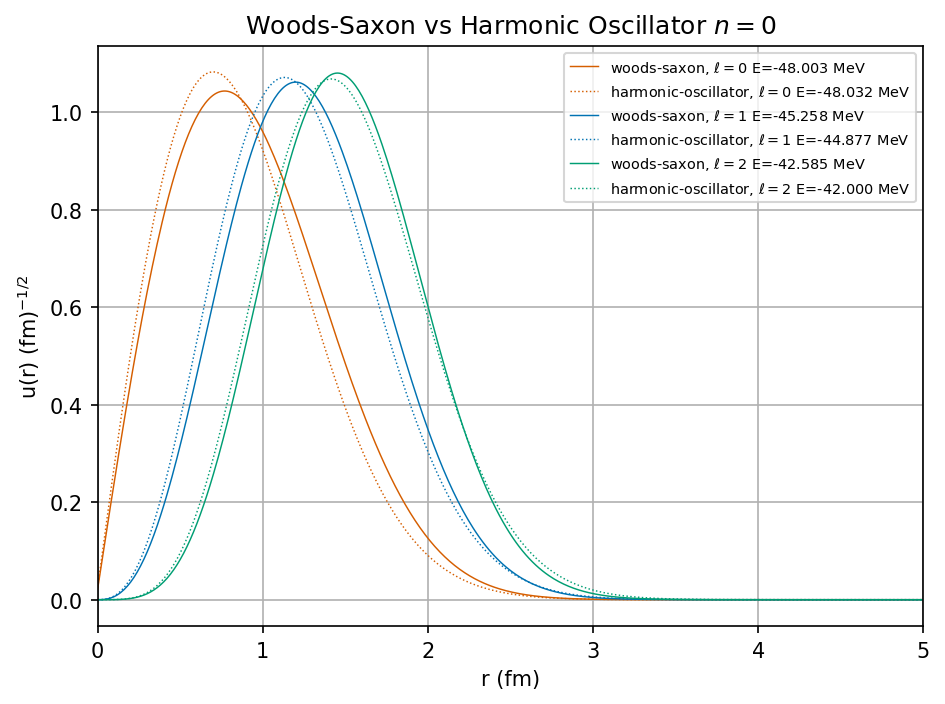

In [150]:
# Plot Woods-Saxon and Harmonic Oscillator wavefunctions
plt.figure(dpi=150)
plot_num = 1
l = 0
for l in l_values:
    for j, potential in enumerate(potential_types):
        if "spin-orbit" == potential:
            pass
        else:
            for i, energy in enumerate(
                dataset[l][potential]["bound_energies"][:plot_num]
            ):
                color = colormap(l)
                plt.plot(
                    r_vect,
                    -dataset[l][potential]["bound_wavefunctions"][:, i],
                    label=rf"{potential}, $\ell = {l}$ E={energy:.3f} MeV",
                    lw=0.7,
                    color=color,
                    ls=line_styles[j],
                )


plt.xlabel("r (fm)")
plt.xlim(0, 5)
plt.ylabel(r"u(r) (fm)$^{-1/2}$")
plt.title(rf"Woods-Saxon vs Harmonic Oscillator $n = {plot_num - 1}$")
plt.legend(loc="upper right", fontsize="x-small")
plt.grid(True)  # Optional: Add a grid for better readability
plt.tight_layout()
# plt.savefig('Num_Methods/RandomNumMethods/ws_ho_n0.png')
plt.show()

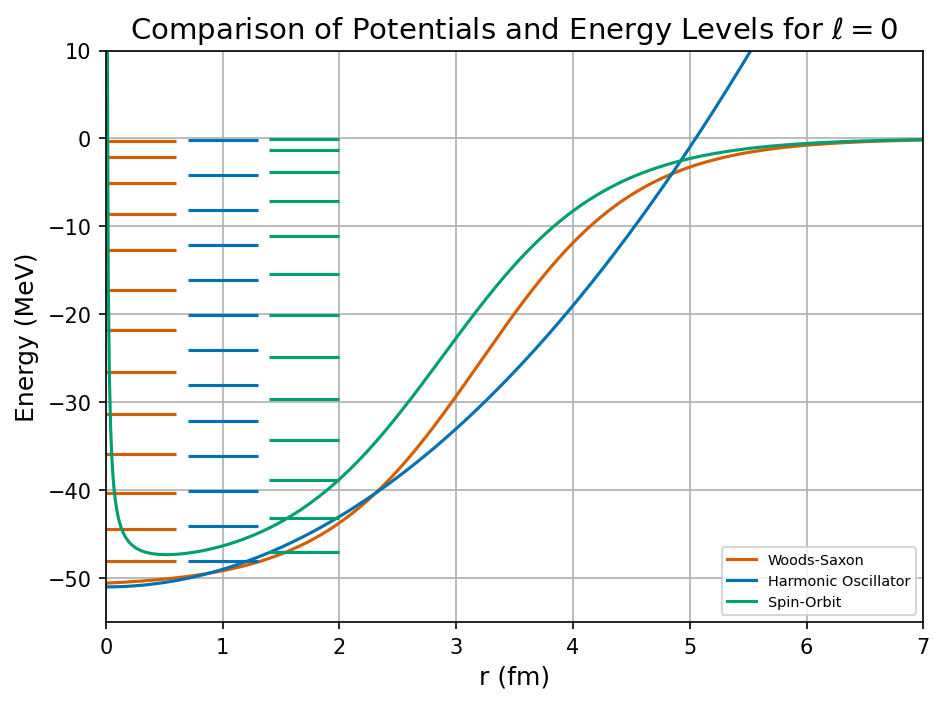

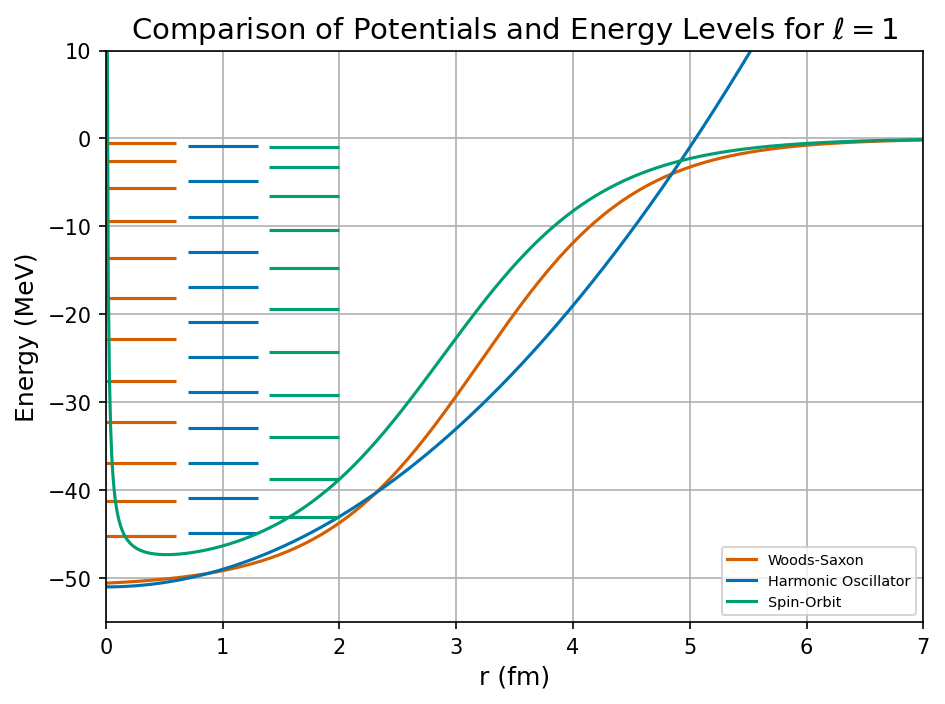

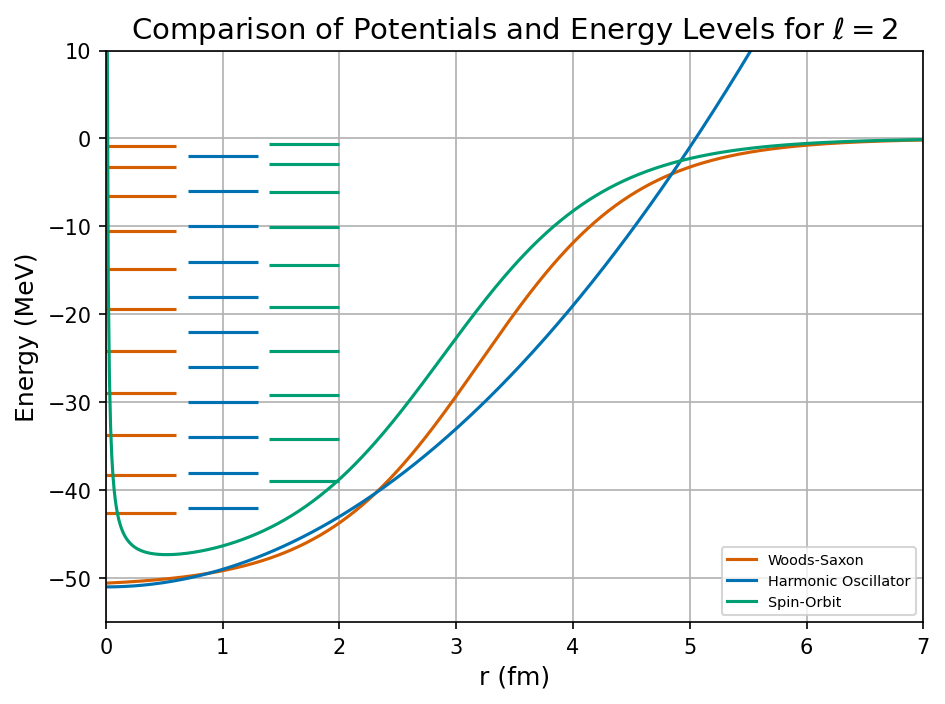

In [153]:
R = r0 * (N + Z) ** (1 / 3)
so_pot = spin_orbit_potential("down", N, Z, "n", r_vect, R, a)
ho_pot = harmonic_oscillator_potential(N, Z, "n", r_vect, omega=2)
ws_pot = woods_saxon_potential(N, Z, "n", r_vect, R, a)
l = 2
for l in l_values:
    # Create a dictionary to store potentials and labels
    potentials_dict = {
        "Woods-Saxon": {
            "potential": ws_pot,
            "color": colormap(0),
            "bound_energies": dataset[l]["woods-saxon"]["bound_energies"],
            "x_range": (0, 0.6),
        },
        "Harmonic Oscillator": {
            "potential": ho_pot,
            "color": colormap(1),
            "bound_energies": dataset[l]["harmonic-oscillator"]["bound_energies"],
            "x_range": (0.7, 1.3),
        },
        "Spin-Orbit": {
            "potential": so_pot,
            "color": colormap(2),
            "bound_energies": dataset[l]["spin-orbit"]["bound_energies"],
            "x_range": (1.4, 2),
        },
    }

    # Plot each potential with its corresponding label and bound energies
    plt.figure(dpi=150)  # Adjust figure size for better readability

    for label, data in potentials_dict.items():
        # Plot the potential
        plt.plot(r_vect, data["potential"], label=label, color=data["color"])

        # Plot the bound energies with horizontal lines
        x_min, x_max = data["x_range"]
        for energy in data["bound_energies"]:
            plt.hlines(
                energy, x_min, x_max, color=data["color"]
            )  # Horizontal line for each energy

    # Adding titles, labels, and a legend
    plt.title(
        rf"Comparison of Potentials and Energy Levels for $\ell = {l}$", fontsize=14
    )
    plt.xlabel("r (fm)", fontsize=12)
    plt.ylabel("Energy (MeV)", fontsize=12)
    plt.ylim(-55, 10)
    plt.xlim(0, 7)  # Adjusting y-axis limits to match your data
    plt.legend(loc="lower right", fontsize="x-small")  # Show legend with labels
    plt.grid(True)  # Optional: Add a grid for better readability
    plt.tight_layout()  # Automatically adjust layout for better fit
    #plt.savefig(f'Num_Methods/RandomNumMethods/energy_level_plots_l{l}.png')
    # Show plot
    plt.show()